<a href="https://colab.research.google.com/github/Neighborc/tlabTutorials/blob/master/UCI_geneclass_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial on UCI splice dataset
The purpose of this tutorial is to give an introdution to processing and evaluating genomic data.
A lot of genome data is kept in .fasta format which basically looks like:

\>IDNumber1 and description

ATCTGCTAGCTAGTCAG......

\>IDNumber2

ATCTCTCT....

Converting these files from nucleotide strings into a useful format for model training and testing is a main purpose of this tutorial. 

This particular dataset involves the task of trying to classify a dataset of genome sequences which are 60 base pairs long and have the classes of: introns, exons, or neither

###This dataset and a more thorough description of the task can be found [here][1]


[1]:https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+(Splice-junction+Gene+Sequences)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import os

### Install Biopython
A great library for handling biological files and data is called [Biopython][1] and has good documentation as well. 

Fun fact you can run command line commands from a Jupyter notebook using the ! command

Run this cell if you need to install Biopython

[1]:https://biopython.org/

In [0]:
!pip install biopython

     |████████████████████████████████| 2.3MB 3.5MB/s 


# Preprocess and clean data
In this case I looked at the data in 'splice.data' and found that it had 3 columns separated by commas and the classes were in the first columns while the sequences were in the third. 

Note after I had already cleaned the data I found an example online of how someone else had done it [here][1]. He does it a bit differently, but it can be good to explore alternatives.


[1]:https://jss367.github.io/Clean-DNA-Dataset.html

__Steps to Take__

Steps:
1. Import the data and visualize
2. Strip the whitespace from the sequences
2. One-hot encode the category
5. Save the file in a cleaner format, in this case fasta. 
This step was done since other genome data is saved in fasta format and this will be helpful for processing other datasets. 
6. Import the file again and encode

In [0]:
# first we just visualize the data
df = pd.read_csv("splice.data", names=['Class', 'Instance', 'Sequence'])
print('Number of samples, columns :', df.shape)
df.head()    

Number of samples, columns : (3190, 3)


,Class,Instance,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [0]:
# Import the file, you may need to adjust path, this assumes it's in cwd
path = os.getcwd()
filename = '/splice.data'
f=open(path + filename,"r")

In [0]:
# puts the data into a list array Nx3, and removes newlines
lines = [line.rstrip('\n') for line in f]

all_items = []
for item in lines:
  # strips whitespace
  items = item.replace(" ","")
  items = items.split(',')
  all_items.append(items)

data_array = np.asarray(all_items)

# takes the useful columns
x_sequences = data_array[:,2]
y_category = data_array[:,0]

__Step 4 Create function for saving to fasta file__

This just makes it easier to manipulate the data later since the second column doesn't provide any useful information. Also other genome data can be in a fasta format. 

In [0]:
def write_sequences_to_fasta(sequences, output_filename):
    """
    Converts an array into a .fasta file format and saves it
    
    Inputs:
      :param sequences: an array with each element is the sequence to be written
      :param output_filename: Location to write the fasta file 
    """
  
    file = open(output_filename, 'w')
    
    for i in range(len(sequences)):
        file.write('>seq' + str(i) + '\n' + sequences[i] + '\n')
    file.close()
    print('Sequences successfully written to ' + output_filename)

In [0]:
# use our function on the sequences we've extracted
write_sequences_to_fasta(x_sequences, path+'/UCIsequences.fa')

Sequences successfully written to /content/UCIsequences.fa


We now have our sequence data saved in a .fasta file. We don't have the labels saved with it though so we should keep track of that separately. You could alter the code to incorporate labels or just include the labels in a separate file which is loaded in with the fasta file. Explore what works best. 

__Label one-hot encoding__

Our final layer of the classifier will be a softmax since we are attempting to classify between 3 different classes. 
Therefore we need to encode the class labels. We can use a tool from scikit-learn to perform this action.

This assigns the values of the categories as such:

EI = [1,0,0]

IE = [0,1,0]

N = [0,0,1]

In [0]:
from sklearn import preprocessing

y_category = y_category.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
enc.fit(y_category)
one_hot_labels = enc.transform(y_category).toarray()
y_data = one_hot_labels

## Encoding DNA Sequences

A typical DNA sequence constists of a string of nucleotides, ATCG. In order to process the data and train with it these need to be encoded numerically. There are several ways to encode such as ordinal, binary, and one-hot

Here I present some examples of how this would  work.

Sequence = GATTACA

Ordinal: A=1, T=2, C=3, G=4, Sequence = [4,1,2,2,1,3,1]

Binary: A = 00, T = 01, C= 10, G = 11, Sequance = [11000101001000]

One-hot: A = [1,0,0,0], T = [0,1,0,0], C = [0,0,1,0], G = [0,0,0,1]

Sequence = $\begin{bmatrix} 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 &  0 \\ 0 & 0 & 1 & 0  \\ 1 & 0 & 0 & 0 \end{bmatrix}$

While the one-hot encoding adds a dimension to the data, it more accurately represents the difference between the different inputs. 

There are also some other base pairs other than ATCG which I chose to encode as proportional values according to their probability. See the guide [here][1] for a description of the bases


[1]:https://en.wikipedia.org/wiki/Nucleic_acid_sequence

In [0]:
# dictionary for replacing the letters in the genome, https://en.wikipedia.org/wiki/Nucleic_acid_sequence
genome_encode_dict = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1],'N':[0.25,0.25,0.25,0.25],
                     'W':[0.5,0,0,0.5],'S':[0,0.5,0.5,0],'M':[0.5,0.5,0,0],'K':[0,0,0.5,0.5],'R':[0.5,0,0.5,0],
                     'Y':[0,0.5,0,0.5],'B':[0,0.333,0.333,0.333],'D':[0.333,0,0.333,0.333],'H':[0.333,0.333,0,0.333],
                     'V':[0.333,0.333,0.333,0],'Z':[0,0,0,0]}

def encodeSequence(encode_dictionary, sequence):
  return np.array([encode_dictionary[x] for x in sequence])

In [0]:
# Here is where we use the BioPython for fasta parsing

from Bio import SeqIO
def one_hot_encode_fasta(filename, encode_dict):
  """
  input: filename of a fasta file 
  output: each of the sequences encoded using the provided dictionary
          dimensions = Number of samples x length of sequences x D(encoded dimension)
  """
  fasta_sequence = SeqIO.parse(open(filename), "fasta")
  splice_array = []
  for fasta in fasta_sequence:
    name, sequence = fasta.id, str(fasta.seq)
    # Here we call the encoding function
    sequence = encodeSequence(encode_dict, sequence.upper())
    splice_array.append(sequence)
  
  return np.asarray(splice_array)


In [0]:
x_data = one_hot_encode_fasta('UCIsequences.fa', genome_encode_dict)

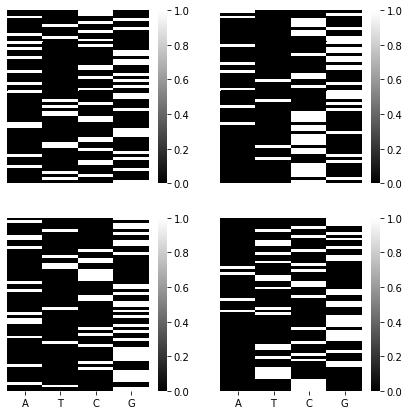

In [0]:
# visualize how these sequences are encoded now
f, axes = plt.subplots(2, 2, figsize=(7, 7))

sns.heatmap(x_data[0], cmap='gray', xticklabels=False, yticklabels=False, ax=axes[0, 0])
sns.heatmap(x_data[1], cmap='gray', xticklabels=False, yticklabels=False, ax=axes[0, 1])
sns.heatmap(x_data[2], cmap='gray', xticklabels=['A','T','C','G'], yticklabels=False, ax=axes[1, 0])
sns.heatmap(x_data[3], cmap='gray', xticklabels=['A','T','C','G'], yticklabels=False, ax=axes[1, 1])
plt.show()

We have now successfully prepared our input data and label data. Keep the dimensions in mind when setting up the input and outputs to the classifier. 

In [0]:
print('x_data shape: ', x_data.shape)
print('y_data shape: ', y_data.shape)

x_data shape:  (3190, 60, 4)
y_data shape:  (3190, 3)


__Setting up the model and splitting the data__

Here we import the libraries we need. 

Probably don't need all of these and can be reduced or increased depending on your model.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
from keras.layers import LSTM
import keras


from sklearn.model_selection import train_test_split

from keras import optimizers
import tensorflow as tf


Using TensorFlow backend.


In [0]:
# split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.2, 
                                                    random_state=1)

print('Number of each class in training: ', np.sum(y_train, axis=0))
print('Number of each class in testing:  ', np.sum(y_test, axis=0))


Number of each class in training:  [ 610.  614. 1328.]
Number of each class in testing:   [157. 154. 327.]


 Note the slight class imbalance. There are as many sequences which are neither as there are sequences for EI and IE combined. This can affect how to interpret your accuracy and you may want to use a different metric. 

In [0]:
# for reproducible results seed random initializers
from numpy.random import seed
from tensorflow import set_random_seed
 
# for reproducibility
seed(1)
set_random_seed(1)

# resets the model to clear it to not build up previous layers
keras.backend.clear_session()


n_hidden = 16
epochs = 20
batch_size = 64

# Here is where we set up the input to be 60 time steps and 4 inputs
input_shape = (x_train.shape[1], x_train.shape[2])

num_classes = 3

model_RNN = Sequential()
model_RNN.add(LSTM(n_hidden, activation='tanh', input_shape=input_shape,
                   return_sequences=True))
model_RNN.add(Flatten())
model_RNN.add(Dropout(0.3)) # dropout to regularize and prevent overfitting

# Here we add the final classification layer
model_RNN.add(Dense(num_classes, activation='softmax'))


optimizer = optimizers.Adam(lr=0.01)

model_RNN.compile(loss='categorical_crossentropy', optimizer=optimizer,
                          metrics=['accuracy'])

history = model_RNN.fit(x_train, y_train, epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test, y_test), verbose=1, 
                    shuffle=True)


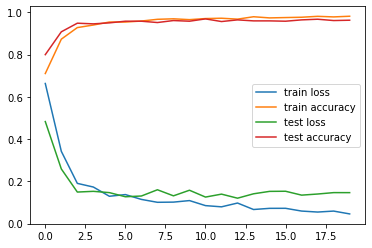

In [0]:
# plot history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['val_acc'], label='test accuracy')
plt.legend()
plt.show()

## Visualize which classes are causing errors
Here we use a confusion matrix to see which class is giving the classifier the most trouble. 

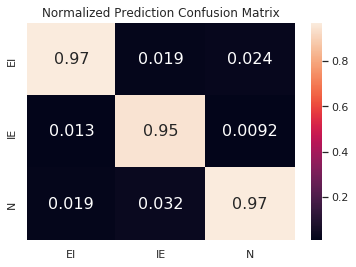

In [0]:
# plot a confusion matrix to show how things are being misclassified
import sklearn.metrics as metrics
import seaborn as sn
%matplotlib inline

y_pred = model_RNN.predict(x_test)
# adjusts the one-hot encoding of the categories
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_labels)

# divides the results by how many are in each class so it is 0 to 1
normalized_confusion_matrix = confusion_matrix.transpose()/confusion_matrix.sum(axis=1)
categories = ['EI','IE','N']

# convert to dataframe to add indexes and to normalize
df_cm = pd.DataFrame(normalized_confusion_matrix, index=categories, columns=categories)

sn.set(font_scale=1.0)
sn.heatmap(df_cm, annot=True, annot_kws={'size':16}).set_title('Normalized Prediction Confusion Matrix')
plt.show()

## Enjoy exploring data

Hopefull this gives you a useful starting spot for evaluating genomic data. There are many other techniques and methods which can be used to evaluate the data.

You could try evaluating multiple base pairs at a time. You could try using a CNN network. Or you could try predicting the next base pair in a sequence instead of classification.  